# Australian Renewable Energy Generation


The aim of this project is to predict how much power a wind or solar farm will generate based on weather conditions.

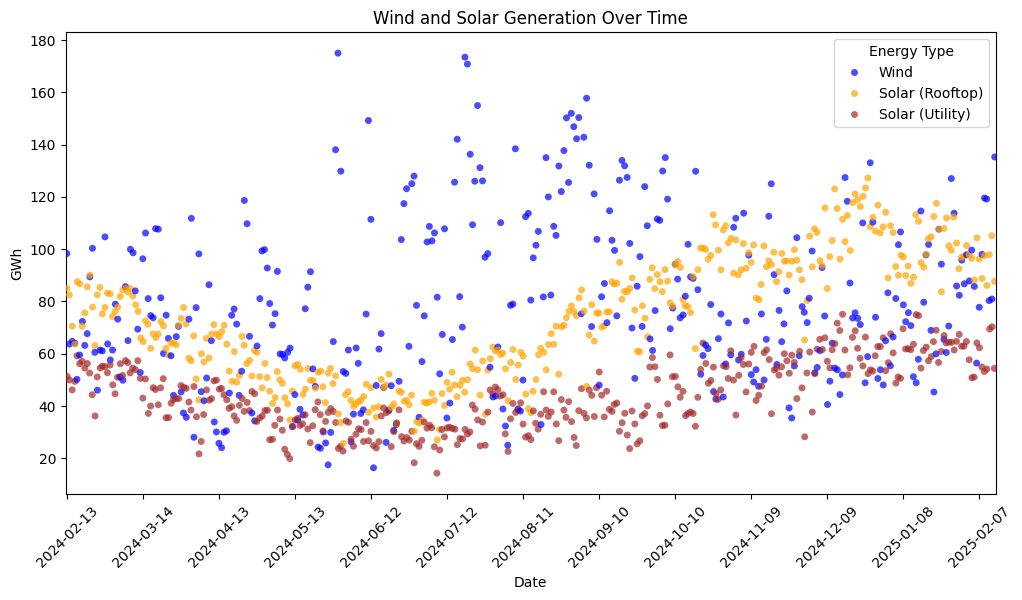

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("2024EnergyGenerationAus.csv")
# print(df.info())
# print(df.describe())

# Visualizing the "Wind - GWh" and "Solar (Rooftop) - GWh" columns over time
# Ensure the date or time column is in datetime format
df['Date'] = pd.to_datetime(df['date'])

# Reshape data to long format for Wind and Solar
df_long = df.melt(
    id_vars='Date', 
    value_vars=['Wind -  GWh', 'Solar (Rooftop) -  GWh', 'Solar (Utility) -  GWh'], 
    var_name='Energy Type', 
    value_name='GWh'
)

# Simplify energy type labels
df_long['Energy Type'] = df_long['Energy Type'].str.replace(' -  GWh', '')

# Plot using stripplot
plt.figure(figsize=(12, 6))
sns.stripplot(
    x='Date', 
    y='GWh', 
    hue='Energy Type', 
    data=df_long, 
    jitter=True, 
    alpha=0.7, 
    palette={'Wind': 'blue', 'Solar (Rooftop)': 'orange', 'Solar (Utility)': 'brown'}
)

# Adding plot labels and title
plt.title('Wind and Solar Generation Over Time')
plt.xlabel('Date')
plt.ylabel('GWh')
plt.xticks(rotation=45)
plt.legend(title='Energy Type')
plt.xticks(ticks=plt.xticks()[0][::30], rotation=45)

# Show plot
plt.show()

Use NASA POWER API to get wind & radiation data for Queensland

In [15]:
import pandas as pd
import numpy as np
import concurrent.futures
from api_fetch import fetch_weather_data

# Define Queensland's approximate lat/lon bounds
latitudes = np.arange(-29, -10, 4)   # South QLD (-29) to North (-10) in 4-degree steps
longitudes = np.arange(138, 154, 4)  # West QLD (138) to East Coast (154) in 4-degree steps

# Parameters for weather data
parameters = "T2M,WS50M,ALLSKY_SFC_SW_DWN" # Temperature, Wind Speed, Solar Radiation
start_date = "20240213"
end_date = "20250213"

# Store results
all_data = []

# Loop through grid points
def fetch_for_location(lat, lon):
    print(f"Fetching data for Lat: {lat}, Lon: {lon}...")
    data = fetch_weather_data(
        parameters=parameters,
        latitude=lat,
        longitude=lon,
        start_date=start_date,
        end_date=end_date
    )
    if data is not None:
        data["Latitude"] = lat
        data["Longitude"] = lon
    return data

# Use ThreadPoolExecutor to make parallel API calls
all_data = []
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    future_to_location = {
        executor.submit(fetch_for_location, lat, lon): (lat, lon)
        for lat in latitudes
        for lon in longitudes
    }

    for future in concurrent.futures.as_completed(future_to_location):
        result = future.result()
        if result is not None:
            all_data.append(result)

# Combine all results into a single DataFrame
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    print(final_df.head())
else:
    print("No data retrieved.")


Fetching data for Lat: -29, Lon: 138...
Fetching data for Lat: -29, Lon: 142...
Fetching data for Lat: -29, Lon: 146...
Fetching data for Lat: -29, Lon: 150...
Fetching data for Lat: -25, Lon: 138...
Fetching data for Lat: -25, Lon: 142...
Fetching data for Lat: -25, Lon: 146...
Fetching data for Lat: -25, Lon: 150...
Fetching data for Lat: -21, Lon: 138...
Fetching data for Lat: -21, Lon: 142...
Fetching data for Lat: -21, Lon: 146...
Fetching data for Lat: -21, Lon: 150...
Fetching data for Lat: -17, Lon: 138...
Fetching data for Lat: -17, Lon: 142...
Fetching data for Lat: -17, Lon: 146...
Fetching data for Lat: -17, Lon: 150...
Fetching data for Lat: -13, Lon: 138...
Fetching data for Lat: -13, Lon: 142...
Fetching data for Lat: -13, Lon: 146...
Fetching data for Lat: -13, Lon: 150...
   YEAR  DOY    T2M  WS50M  ALLSKY_SFC_SW_DWN  Latitude  Longitude
0  2024   44  27.47   6.03              17.58       -25        146
1  2024   45  28.15   4.27              20.43       -25        146